# Image Segmentation with U-Net

U-Net improves on the Fully Convolutional Network, or FCN, using a somewhat similar design, but differing in some important ways.  Instead of one transposed convolution at the end of the network, it uses a matching number of convolutions for downsampling the input image to a feature map, and transposed convolutions for upsampling those maps back up to the original input image size. It also adds skip connections, to retain information that would otherwise become lost during encoding. Skip connections send information to every upsampling layer in the decoder from the corresponding downsampling layer in the encoder, capturing finer information while also keeping computation low. These help prevent information loss, as well as model overfitting. 

Phases:
  1. Implement semantic image segmentation on the CARLA self-driving car dataset
  2. Apply sparse categorical crossentropy for pixelwise prediction 

In [ ]:
import tensorflow as tf
import numpy as np

from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout 
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate

from test_utils import summary, comparator

<a name='2'></a>
## Load and Split the Data

In [ ]:
import os
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import imageio

import matplotlib.pyplot as plt
%matplotlib inline

path = ''
image_path = os.path.join(path, './data/CameraRGB/')
mask_path = os.path.join(path, './data/CameraMask/')
image_list = os.listdir(image_path)
mask_list = os.listdir(mask_path)
image_list = [image_path+i for i in image_list]
mask_list = [mask_path+i for i in mask_list]

Text(0.5, 1.0, 'Segmentation')

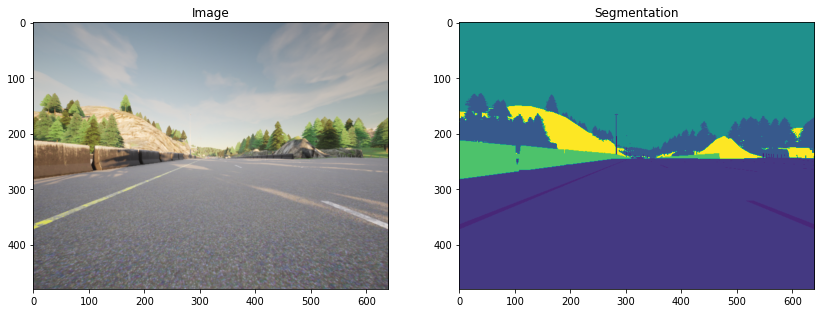

In [ ]:
N = 2
img = imageio.imread(image_list[N])
mask = imageio.imread(mask_list[N])
#mask = np.array([max(mask[i, j]) for i in range(mask.shape[0]) for j in range(mask.shape[1])]).reshape(img.shape[0], img.shape[1])

fig, arr = plt.subplots(1, 2, figsize=(14, 10))
arr[0].imshow(img)
arr[0].set_title('Image')
arr[1].imshow(mask[:, :, 0])
arr[1].set_title('Segmentation')

In [ ]:
image_list_ds = tf.data.Dataset.list_files(image_list, shuffle=False)
mask_list_ds = tf.data.Dataset.list_files(mask_list, shuffle=False)

for path in zip(image_list_ds.take(3), mask_list_ds.take(3)):
    print(path)

(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000026.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000026.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000027.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000027.png'>)
(<tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraRGB/000028.png'>, <tf.Tensor: shape=(), dtype=string, numpy=b'./data/CameraMask/000028.png'>)


In [ ]:
image_filenames = tf.constant(image_list)
masks_filenames = tf.constant(mask_list)

dataset = tf.data.Dataset.from_tensor_slices((image_filenames, masks_filenames))

for image, mask in dataset.take(1):
    print(image)
    print(mask)

tf.Tensor(b'./data/CameraRGB/002128.png', shape=(), dtype=string)
tf.Tensor(b'./data/CameraMask/002128.png', shape=(), dtype=string)


In [ ]:
def process_path(image_path, mask_path):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_png(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)

    mask = tf.io.read_file(mask_path)
    mask = tf.image.decode_png(mask, channels=3)
    mask = tf.math.reduce_max(mask, axis=-1, keepdims=True)
    return img, mask

def preprocess(image, mask):
    input_image = tf.image.resize(image, (96, 128), method='nearest')
    input_mask = tf.image.resize(mask, (96, 128), method='nearest')

    return input_image, input_mask

image_ds = dataset.map(process_path)
processed_image_ds = image_ds.map(preprocess)

<a name='3'></a>
## Build the U-Net

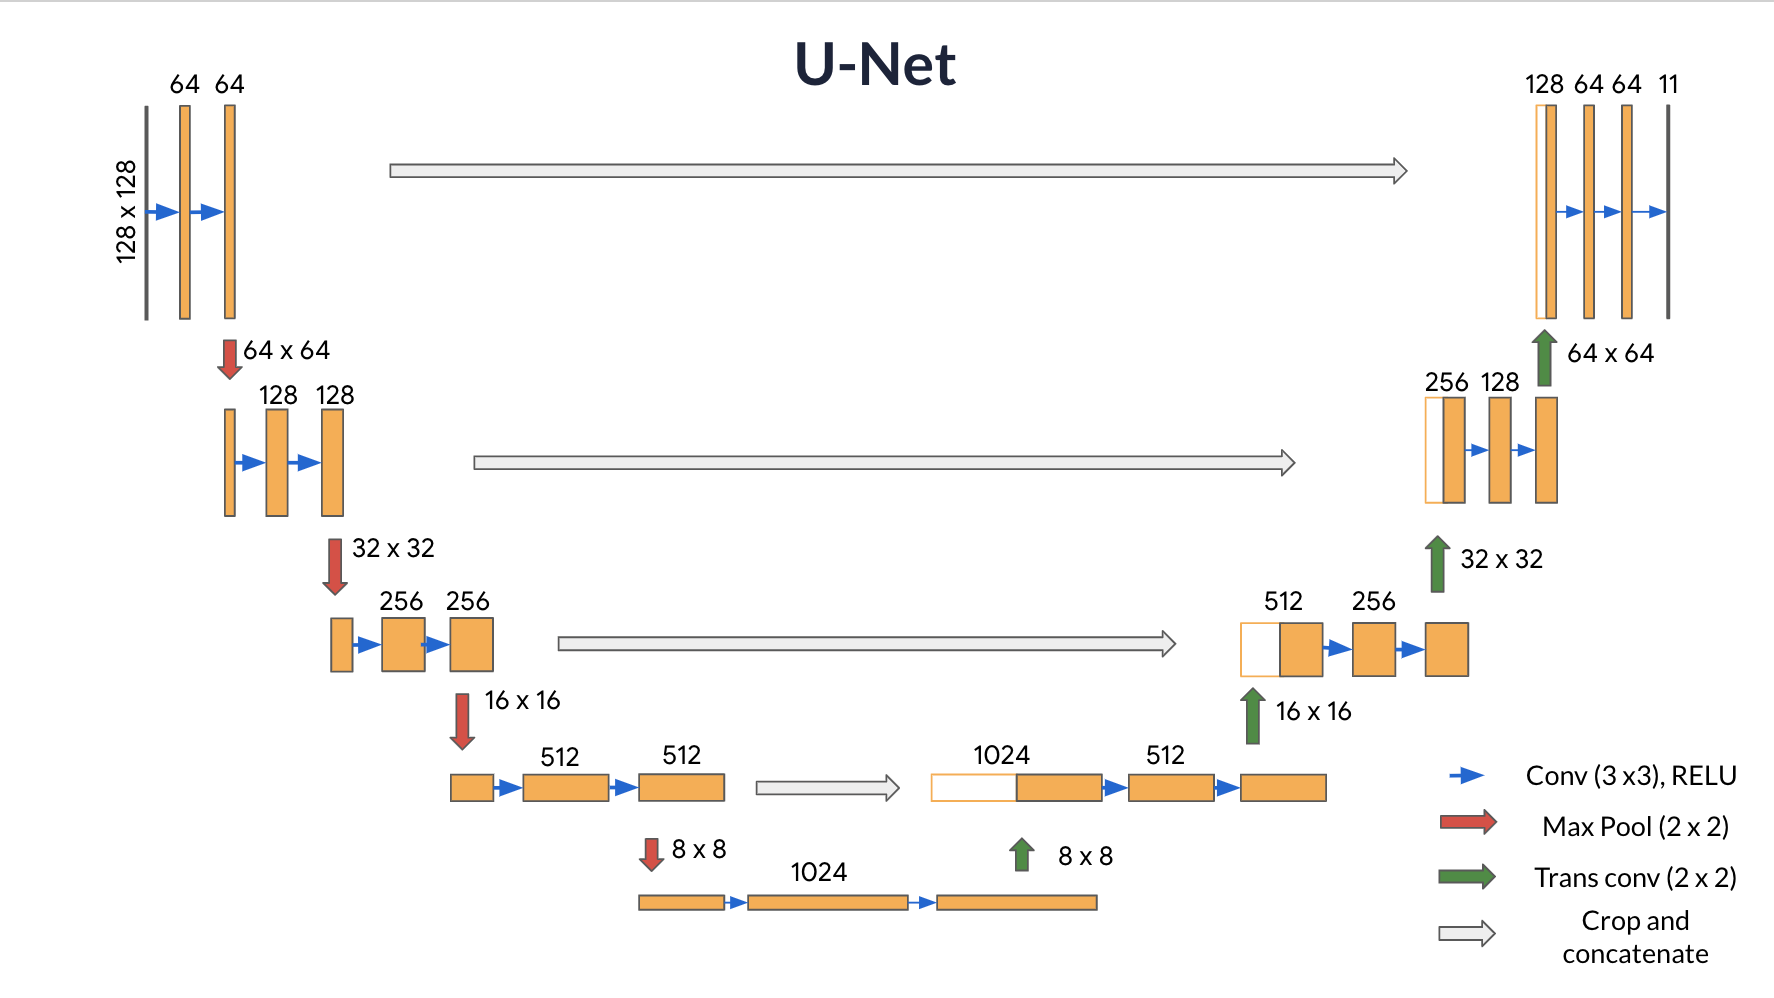

In [ ]:
def conv_block(inputs=None, n_filters=32, dropout_prob=0, max_pooling=True):
    """
    Convolutional downsampling block
    
    Arguments:
        inputs -- Input tensor
        n_filters -- Number of filters for the convolutional layers
        dropout_prob -- Dropout probability
        max_pooling -- Use MaxPooling2D to reduce the spatial dimensions of the output volume
    Returns: 
        next_layer, skip_connection --  Next layer and skip connection outputs
    """
    conv = Conv2D(n_filters,
                  3,   
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(inputs)
    conv = Conv2D(n_filters,
                  3,
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    if dropout_prob > 0:
        conv = Dropout(dropout_prob)(conv)

    if max_pooling:
        next_layer = MaxPooling2D(pool_size = (2, 2))(conv)
        
    else:
        next_layer = conv
        
    skip_connection = conv
    
    return next_layer, skip_connection

In [ ]:
input_size=(96, 128, 3)
n_filters = 32
inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output1 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal'],
            ['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]]

print('Block 1:')
for layer in summary(model1):
    print(layer)

inputs = Input(input_size)
cblock1 = conv_block(inputs, n_filters * 32, dropout_prob=0.1, max_pooling=True)
model2 = tf.keras.Model(inputs=inputs, outputs=cblock1)

output2 = [['InputLayer', [(None, 96, 128, 3)], 0],
            ['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal'],
            ['Dropout', (None, 96, 128, 1024), 0, 0.1],
            ['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]]
           
print('\nBlock 2:')   
for layer in summary(model2):
    print(layer)


Block 1:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 32), 896, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 32), 9248, 'same', 'relu', 'HeNormal']
['MaxPooling2D', (None, 48, 64, 32), 0, (2, 2)]

Block 2:
['InputLayer', [(None, 96, 128, 3)], 0]
['Conv2D', (None, 96, 128, 1024), 28672, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 96, 128, 1024), 9438208, 'same', 'relu', 'HeNormal']
['Dropout', (None, 96, 128, 1024), 0, 0.1]
['MaxPooling2D', (None, 48, 64, 1024), 0, (2, 2)]


In [ ]:
def upsampling_block(expansive_input, contractive_input, n_filters=32):
    """
    Convolutional upsampling block
    
    Arguments:
        expansive_input -- Input tensor from previous layer
        contractive_input -- Input tensor from previous skip layer
        n_filters -- Number of filters for the convolutional layers
    Returns: 
        conv -- Tensor output
    """
    up = Conv2DTranspose(
                 n_filters, 
                 3, 
                 strides = (2, 2),
                 padding = 'same')(expansive_input)
    
    merge = concatenate([up, contractive_input], axis=3)
    conv = Conv2D(n_filters,
                  3,
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(merge)
    
    conv = Conv2D(n_filters,
                  3,
                  activation = 'relu',
                  padding = 'same',
                  kernel_initializer = 'he_normal')(conv)
    
    return conv

In [ ]:
input_size1=(12, 16, 256)
input_size2 = (24, 32, 128)
n_filters = 32
expansive_inputs = Input(input_size1)
contractive_inputs =  Input(input_size2)
cblock1 = upsampling_block(expansive_inputs, contractive_inputs, n_filters * 1)
model1 = tf.keras.Model(inputs=[expansive_inputs, contractive_inputs], outputs=cblock1)

output1 = [['InputLayer', [(None, 12, 16, 256)], 0],
            ['Conv2DTranspose', (None, 24, 32, 32), 73760],
            ['InputLayer', [(None, 24, 32, 128)], 0],
            ['Concatenate', (None, 24, 32, 160), 0],
            ['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal'],
            ['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']]

print('Block 1:')
for layer in summary(model1):
    print(layer)

Block 1:
['InputLayer', [(None, 12, 16, 256)], 0]
['Conv2DTranspose', (None, 24, 32, 32), 73760]
['InputLayer', [(None, 24, 32, 128)], 0]
['Concatenate', (None, 24, 32, 160), 0]
['Conv2D', (None, 24, 32, 32), 46112, 'same', 'relu', 'HeNormal']
['Conv2D', (None, 24, 32, 32), 9248, 'same', 'relu', 'HeNormal']


<a name='3-4'></a>
### Building the Model

In [ ]:
def unet_model(input_size=(96, 128, 3), n_filters=32, n_classes=23):
    """
    Unet model
    
    Arguments:
        input_size -- Input shape 
        n_filters -- Number of filters for the convolutional layers
        n_classes -- Number of output classes
    Returns: 
        model -- tf.keras.Model
    """
    inputs = Input(input_size)
    cblock1 = conv_block(inputs, n_filters)
    cblock2 = conv_block(cblock1[0], n_filters * 2)
    cblock3 = conv_block(cblock2[0], n_filters * 4)
    cblock4 = conv_block(cblock3[0], n_filters * 8, dropout_prob = 0.3)
    cblock5 = conv_block(cblock4[0], n_filters * 16, dropout_prob = 0.3, max_pooling = None)
    ublock6 = upsampling_block(cblock5[0], cblock4[1], n_filters * 8)
    ublock7 = upsampling_block(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = upsampling_block(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = upsampling_block(ublock8, cblock1[1],  n_filters)

    conv9 = Conv2D(n_filters,
                 3,
                 activation = 'relu',
                 padding = 'same',
                 kernel_initializer = 'he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding = 'same')(conv9)    
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

In [ ]:
import outputs
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))


In [ ]:
img_height = 96
img_width = 128
num_channels = 3

unet = unet_model((img_height, img_width, num_channels))

In [ ]:
unet.summary()

Model: "functional_9"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_6 (InputLayer)            [(None, 96, 128, 3)] 0                                            
__________________________________________________________________________________________________
conv2d_26 (Conv2D)              (None, 96, 128, 32)  896         input_6[0][0]                    
__________________________________________________________________________________________________
conv2d_27 (Conv2D)              (None, 96, 128, 32)  9248        conv2d_26[0][0]                  
__________________________________________________________________________________________________
max_pooling2d_6 (MaxPooling2D)  (None, 48, 64, 32)   0           conv2d_27[0][0]                  
_______________________________________________________________________________________

In [ ]:
unet.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [ ]:
def display(display_list):
    plt.figure(figsize=(15, 15))

    title = ['Input Image', 'True Mask', 'Predicted Mask']

    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(title[i])
        plt.imshow(tf.keras.preprocessing.image.array_to_img(display_list[i]))
        plt.axis('off')
    plt.show()

(480, 640, 1)


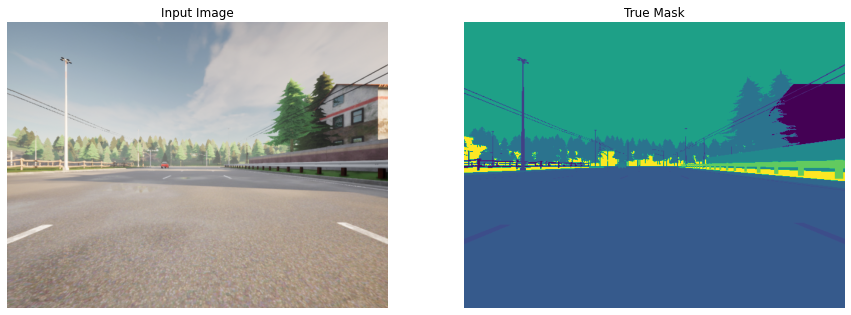

In [ ]:
for image, mask in image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

(96, 128, 1)


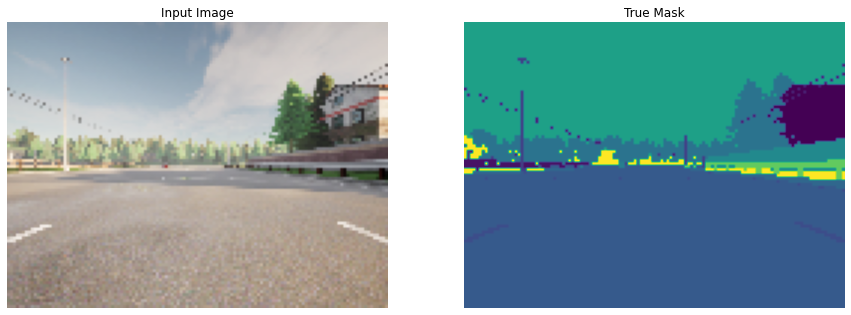

In [ ]:
for image, mask in processed_image_ds.take(1):
    sample_image, sample_mask = image, mask
    print(mask.shape)
display([sample_image, sample_mask])

<a name='4'></a>
## Training the Model

In [ ]:
EPOCHS = 40
VAL_SUBSPLITS = 5
BUFFER_SIZE = 500
BATCH_SIZE = 32
processed_image_ds.batch(BATCH_SIZE)
train_dataset = processed_image_ds.cache().shuffle(BUFFER_SIZE).batch(BATCH_SIZE)
print(processed_image_ds.element_spec)
model_history = unet.fit(train_dataset, epochs=EPOCHS)

(TensorSpec(shape=(96, 128, 3), dtype=tf.float32, name=None), TensorSpec(shape=(96, 128, 1), dtype=tf.uint8, name=None))
Epoch 1/40
34/34 [==============================] - 15s 450ms/step - loss: 1.8526 - accuracy: 0.4753
Epoch 2/40
34/34 [==============================] - 1s 41ms/step - loss: 0.8941 - accuracy: 0.7563
Epoch 3/40
34/34 [==============================] - 1s 41ms/step - loss: 0.5829 - accuracy: 0.8196
Epoch 4/40
34/34 [==============================] - 1s 40ms/step - loss: 0.5008 - accuracy: 0.8429
Epoch 5/40
34/34 [==============================] - 1s 40ms/step - loss: 0.4425 - accuracy: 0.8637
Epoch 6/40
34/34 [==============================] - 1s 40ms/step - loss: 0.4355 - accuracy: 0.8691
Epoch 7/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3590 - accuracy: 0.8909
Epoch 8/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3559 - accuracy: 0.8930
Epoch 9/40
34/34 [==============================] - 1s 40ms/step - loss: 0.3013 - acc

<a name='4-1'></a>
### 4.1 - Create Predicted Masks 

Now, define a function that uses `tf.argmax` in the axis of the number of classes to return the index with the largest value and merge the prediction into a single image:

In [ ]:
def create_mask(pred_mask):
    pred_mask = tf.argmax(pred_mask, axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]
    return pred_mask[0]

<a name='4-2'></a>
###  Plot Model Accuracy
 

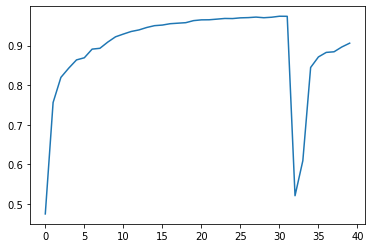

In [ ]:
plt.plot(model_history.history["accuracy"])

<a name='4-3'></a>
### Predictions 

In [ ]:
def show_predictions(dataset=None, num=1):
    """
    Displays the first image of each of the num batches
    """
    if dataset:
        for image, mask in dataset.take(num):
            pred_mask = unet.predict(image)
            display([image[0], mask[0], create_mask(pred_mask)])
    else:
        display([sample_image, sample_mask,
             create_mask(unet.predict(sample_image[tf.newaxis, ...]))])

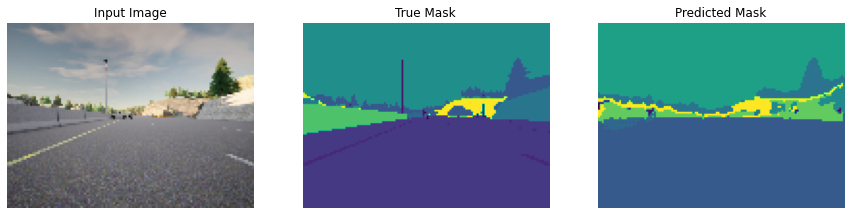

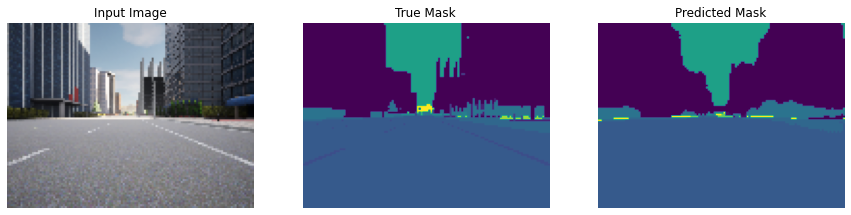

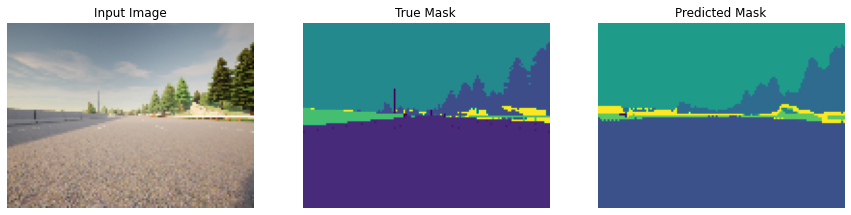

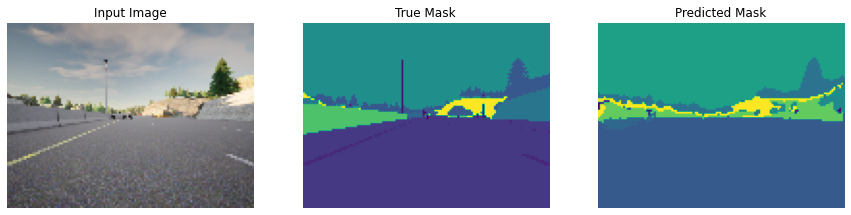

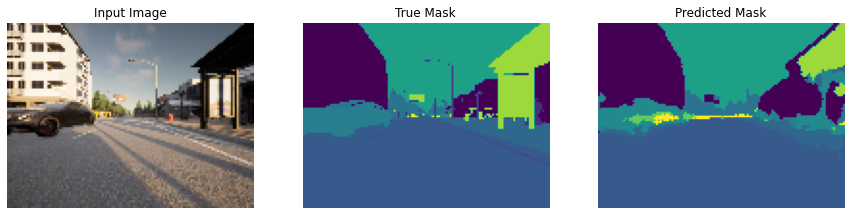

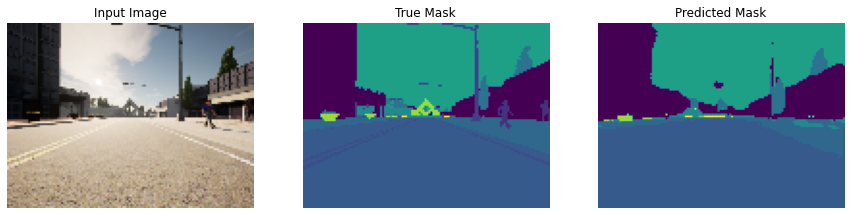

In [ ]:
show_predictions(train_dataset, 6)